# RNA modification analysis tutorial with xPore

This tutorial is intended as a simple guide for performing RNA modification analysis using xPore, a software that performs differential RNA modification analysis. The tutorial will use an eventalign.txt file outputted from nanopolish to demonstrate how to preprocess these files and perform differnetial RNA modification analysis.

The tutorial provides a HEK293T wildtype (HEK293_WT), a HEK293T METTL3 knockout (HEK293T_KO), and subsetted reference fasta and gtf, and the workflow can be used to address such questions as:

<ul><li>How to find differential RNA modification sites?</li></ul>
Methods used in this tutorial include:
<ul>
<li>Basecalling with guppy (command provided but will not be run)</li>
<li>Alignment of the basecalled.fastq file to a transcriptome.fasta using minimap2 (command provided but will not be run)</li>
<li>Segmentation of the current signals (fast5) with nanopolish (command provided but will not be run)</li>
<li>Preparing data with xpore dataprep</li>
<li>Finding Differential RNA modification sites with xpore diffmod</li>
<li>Postprocessing xpore diffmod output table with xpore postprocessing</li>
</ul>
Computational requirements for this tutorial include:
<ul>
<li>Computer running the EPI2ME Labs notebook Server</li>
<li>At least 8 Gb RAM</li>
</ul>

## Data preparation from raw reads
### Basecalling with guppy


In [1]:
## basecalling with guppy
# guppy_basecaller -i </PATH/TO/FAST5> -s </PATH/TO/FASTQ> --flowcell <FLOWCELL_ID> --kit <KIT_ID> --device auto -q 0 -r

### Alignment of the basecalled.fastq file to a transcriptome.fasta using minimap2

In [2]:
## index transcriptome fasta
# minimap2 -ax map-ont -uf -t 3 --secondary=no -d <MMI> <TRANSCRIPTOME.FASTA>

## align fastq to transcriptome
# minimap2 -ax map-ont -uf -t 3 --secondary=no <MMI> <PATH/TO/FASTQ.GZ> > <PATH/TO/SAM> 2>> <PATH/TO/SAM_LOG>

## convert .sam file from minimap2 to bam using samtools view
# samtools view -Sb <PATH/TO/SAM> | samtools sort -o <PATH/TO/BAM> - &>> <PATH/TO/BAM_LOG>

## index bam file with samtools index
# samtools index <PATH/TO/BAM> &>> <PATH/TO/BAM_INDEX_LOG>

### Segmentation of the current signals (fast5) with nanopolish

In [3]:
## index fastq reads with fast5 files
# nanopolish index -d <PATH/TO/FAST5_DIR> <PATH/TO/FASTQ_FILE>

## run nanopolish eventalign
# nanopolish eventalign --reads <PATH/TO/FASTQ_FILE> \
# --bam <PATH/TO/BAM_FILE> \
# --genome <PATH/TO/FASTA_FILE \
# --signal-index \
# --scale-events \
# --summary <PATH/TO/summary.txt> \
# --threads 32 > <PATH/TO/eventalign.txt>

## xPore differential RNA modification analysis
### Download test dataset

In [27]:
!wget https://zenodo.org/record/5162402/files/demo.tar.gz
!tar -xf demo.tar.gz
!mv ./demo/* .

--2021-11-01 18:03:43--  https://zenodo.org/record/5162402/files/demo.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84504086 (81M) [application/octet-stream]
Saving to: ‘demo.tar.gz’

demo.tar.gz         100%[===================>]  80.59M  1.52MB/s    in 6m 5s   

2021-11-01 18:09:50 (226 KB/s) - ‘demo.tar.gz’ saved [84504086/84504086]



We can have a look at the data

In [29]:
!ls data/*

data/HEK293T-METTL3-KO-rep1:
bamtx  fast5  fastq  nanopolish

data/HEK293T-WT-rep1:
bamtx  fast5  fastq  nanopolish


xpore uses the eventalign.txt from nanopolish as input

In [30]:
!ls data/*/nanopolish

data/HEK293T-METTL3-KO-rep1/nanopolish:
eventalign.txt	summary.txt

data/HEK293T-WT-rep1/nanopolish:
eventalign.txt	summary.txt


### Install xPore

In [31]:
!pip install xpore

You can check xPore's version by typing the following:

In [32]:
!xpore --version

xpore 2.0


#### xPore contains the following functions: 
##### 1) dataprep

In [33]:
!xpore dataprep -h

usage: xpore dataprep [-h] --eventalign EVENTALIGN --out_dir OUT_DIR
                      [--gtf_or_gff GTF_OR_GFF]
                      [--transcript_fasta TRANSCRIPT_FASTA]
                      [--skip_eventalign_indexing] [--genome]
                      [--n_processes N_PROCESSES] [--chunk_size CHUNK_SIZE]
                      [--readcount_min READCOUNT_MIN]
                      [--readcount_max READCOUNT_MAX] [--resume]

required arguments:
  --eventalign EVENTALIGN
                        eventalign filepath, the output from nanopolish.
  --out_dir OUT_DIR     output directory.

optional arguments:
  -h, --help            show this help message and exit
  --gtf_or_gff GTF_OR_GFF
                        GTF or GFF file path.
  --transcript_fasta TRANSCRIPT_FASTA
                        transcript FASTA path.
  --skip_eventalign_indexing
                        skip indexing the eventalign nanopolish output.
  --genome              to run on Genomic coordinates. Without this a

##### 2) diffmod

In [34]:
!xpore diffmod -h

usage: xpore diffmod [-h] --config CONFIG [--n_processes N_PROCESSES]
                     [--save_models] [--resume] [--ids [IDS [IDS ...]]]

required arguments:
  --config CONFIG       YAML configuraion filepath.

optional arguments:
  -h, --help            show this help message and exit
  --n_processes N_PROCESSES
                        number of processes to run.
  --save_models         with this argument, the program will save the model
                        parameters for each id.
  --resume              with this argument, the program will resume from the
                        previous run.
  --ids [IDS [IDS ...]]
                        gene or transcript ids to model.


##### 3) postprocessing

In [35]:
!xpore postprocessing -h

usage: xpore postprocessing [-h] --diffmod_dir DIFFMOD_DIR

optional arguments:
  -h, --help            show this help message and exit

required arguments:
  --diffmod_dir DIFFMOD_DIR
                        diffmod directory path, the output from xpore-diffmod.


### Preparing data with xpore dataprep
Preprocess the data for each data set using xpore dataprep. Note that the --gtf_path_or_url and --transcript_fasta_paths_or_urls arguments are required to map transcriptomic to genomic coordinates when the --genome option is chosen, so that xPore can run based on genome coordinates. (This step will take approximately 5h for 1 million reads). The warning messages can be ignore:

In [ ]:
## genome alignment -- entries are in genomic position
# preprocess HEK293T-METTL3-KO-rep1
!xpore dataprep --eventalign data/HEK293T-METTL3-KO-rep1/nanopolish/eventalign.txt\
--out_dir data/HEK293T-METTL3-KO-rep1/gene_dataprep\
--genome\
--gtf_or_gff demo.gtf\
--transcript_fasta demo.fa
# preprocess HEK293T-WT-rep1
!xpore dataprep --eventalign data/HEK293T-WT-rep1/nanopolish/eventalign.txt\
--out_dir data/HEK293T-WT-rep1/gene_dataprep\
--genome\
--gtf_or_gff demo.gtf\
--transcript_fasta demo.fa

## transcript alignment -- entries are in transcriptomic position
# preprocess HEK293T-METTL3-KO-rep1
!xpore dataprep --eventalign data/HEK293T-METTL3-KO-rep1/nanopolish/eventalign.txt\
--out_dir data/HEK293T-METTL3-KO-rep1/dataprep
# preprocess HEK293T-WT-rep1
!xpore dataprep --eventalign data/HEK293T-WT-rep1/nanopolish/eventalign.txt\
--out_dir data/HEK293T-WT-rep1/dataprep

The output files are stored under dataprep in each dataset directory:
<ul>
<li>eventalign.index : Index file to access eventalign.txt, the output from nanopolish eventalign</li>
<li>data.json : Preprocessed data for xpore-diffmod</li>
<li>data.index : File index of data.json for random access per gene</li>
<li>data.readcount : Summary of readcounts per gene</li>
<li>data.log : Log file</li>
</ul>

In [39]:
!ls -lh data/*/*dataprep

data/HEK293T-METTL3-KO-rep1/dataprep:
total 1.9M
-rw-rw-r-- 1 wanyk wanyk  411 Nov  1 18:14 data.index
-rw-rw-r-- 1 wanyk wanyk 1.8M Nov  1 18:14 data.json
-rw-rw-r-- 1 wanyk wanyk  353 Nov  1 18:14 data.log
-rw-rw-r-- 1 wanyk wanyk  259 Nov  1 18:14 data.readcount
-rw-rw-r-- 1 wanyk wanyk  12K Nov  1 18:14 eventalign.index

data/HEK293T-METTL3-KO-rep1/gene_dataprep:
total 1.7M
-rw-rw-r-- 1 wanyk wanyk   70 Nov  1 18:13 data.index
-rw-rw-r-- 1 wanyk wanyk 1.6M Nov  1 18:13 data.json
-rw-rw-r-- 1 wanyk wanyk   89 Nov  1 18:13 data.log
-rw-rw-r-- 1 wanyk wanyk   52 Nov  1 18:13 data.readcount
-rw-rw-r-- 1 wanyk wanyk  12K Nov  1 18:13 eventalign.index

data/HEK293T-WT-rep1/dataprep:
total 1.1M
-rw-rw-r-- 1 wanyk wanyk  337 Nov  1 18:14 data.index
-rw-rw-r-- 1 wanyk wanyk 1.1M Nov  1 18:14 data.json
-rw-rw-r-- 1 wanyk wanyk  303 Nov  1 18:14 data.log
-rw-rw-r-- 1 wanyk wanyk  215 Nov  1 18:14 data.readcount
-rw-rw-r-- 1 wanyk wanyk 6.3K Nov  1 18:14 eventalign.index

data/HEK293T-WT-rep1/

### Finding Differential RNA modification sites with xpore diffmod
Prepare a .yml configuration file. With this YAML file, you can specify the information of your design experiment, the data directories, the output directory, and the method options. In the demo directory, there is an example configuration file Hek293T_config.yaml available that you can use as a starting template. Below is how it looks like:

In [40]:
!cat Hek293T_config.yml

notes: Pairwise comparison without replicates with default parameter setting.

data:
    KO:
        rep1: ./data/HEK293T-METTL3-KO-rep1/dataprep
    WT:
        rep1: ./data/HEK293T-WT-rep1/dataprep    
    
out: ./out

method:
    prefiltering:
        method: t-test
        threshold: 0.1



Now that we have the data and the configuration file ready for modelling differential modifications using xpore-diffmod.

In [41]:
!xpore diffmod --config Hek293T_config.yml --n_processes 1

Using the signal of unmodified RNA from /usr/local/lib/python3.6/dist-packages/xpore-2.0-py3.6.egg/xpore/diffmod/model_kmer.csv
8 ids to be testing ...


The output files are generated within the out directory:
<ul>
<li>diffmod.table : Result table of differential RNA modification across all tested positions</li>
<li>diffmod.log : Log file</li>
</ul>

In [42]:
!ls out

diffmod.log  diffmod.table  models


### Postprocessing xpore diffmod output table with xpore postprocessing
(Optional) We can consider only one modification type per k-mer by finding the majority mod_assignment of each k-mer. For example, the majority of the modification means of GGACT (mu_mod) is lower than the non-modification counterpart (mu_unmod). We can filter out those positions whose mod_assigment values are not in line with those of the majority in order to restrict ourselves with one modification type per kmer in the analysis. This can be done by running xpore postprocessing.

In [43]:
!xpore postprocessing --diffmod out

An addtional majority_direction_kmer_diffmod.table is generated in the out directory:

In [44]:
!ls out

diffmod.log  diffmod.table  majority_direction_kmer_diffmod.table  models


The steps above demonstrated how to run xPore to obtain the differential RNA modification result table using a test dataset. 

# Analyze the differential RNA modification results
The steps below will show the analysis of a full dataset based on Supplementary Data 3 from [xPore's publication](https://www.nature.com/articles/s41587-021-00949-w). This Supplementary table merges the xPore diffmod outputs of all sites tested in HEK293T KO, HEK293T KD, and HEK293T WT samples and has an additional column called m6ACE-Seq, which is the ground truth used in the study and is not a part of the xpore diffmod output. 

The following analysis will compare only HEK293T KO and HEK293T WT to show how to interpret the differential modification rate (DMR).

### Download xpore diffmod result table of a full dataset

In [45]:
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-021-00949-w/MediaObjects/41587_2021_949_MOESM5_ESM.csv
!mv 41587_2021_949_MOESM5_ESM.csv test_diffmod.table

--2021-11-01 18:15:16--  https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-021-00949-w/MediaObjects/41587_2021_949_MOESM5_ESM.csv
Resolving static-content.springer.com (static-content.springer.com)... 199.232.44.95
Connecting to static-content.springer.com (static-content.springer.com)|199.232.44.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32602029 (31M) [application/octet-stream]
Saving to: ‘41587_2021_949_MOESM5_ESM.csv’

41587_2021_949_MOES 100%[===================>]  31.09M  12.2MB/s    in 2.5s    

2021-11-01 18:15:19 (12.2 MB/s) - ‘41587_2021_949_MOESM5_ESM.csv’ saved [32602029/32602029]



Let's look at the first three lines of the table, which includes the header and two xPore reported sites:

In [46]:
!head -n 3 test_diffmod.table

chr,id,position,kmer,m6ACE-Seq,coverage_HEK293T-KO-rep1,coverage_HEK293T-KO-rep2,coverage_HEK293T-KO-rep3,coverage_HEK293T-KD-rep1,coverage_HEK293T-KD-rep2,coverage_HEK293T-KD-rep3,coverage_HEK293T-WT-rep1,coverage_HEK293T-WT-rep2,coverage_HEK293T-WT-rep3,mod_rate_HEK293T-KO-rep1,mod_rate_HEK293T-KO-rep2,mod_rate_HEK293T-KO-rep3,mod_rate_HEK293T-KD-rep1,mod_rate_HEK293T-KD-rep2,mod_rate_HEK293T-KD-rep3,mod_rate_HEK293T-WT-rep1,mod_rate_HEK293T-WT-rep2,mod_rate_HEK293T-WT-rep3,diff_mod_rate_HEK293T-KO_vs_HEK293T-WT,diff_mod_rate_HEK293T-KD_vs_HEK293T-KO,diff_mod_rate_HEK293T-KD_vs_HEK293T-WT,z_score_HEK293T-KO_vs_HEK293T-WT,z_score_HEK293T-KD_vs_HEK293T-KO,z_score_HEK293T-KD_vs_HEK293T-WT,pval_HEK293T-KO_vs_HEK293T-WT,pval_HEK293T-KD_vs_HEK293T-KO,pval_HEK293T-KD_vs_HEK293T-WT,mu_unmod,mu_mod,sigma2_unmod,sigma2_mod,conf_mu_unmod,conf_mu_mod,mod_assignment
12,ENSG00000075415,98601549,GGACT,True,883.0000000000008,970.0,961.9999999999992,964.0,753.0000000000003,449.00000000000017,759.0000

### Scatter plot of the p-value and the differential modification rate of nnAnn kmers
Here we plot the -log10(p-value) against the differential modification rate (DMR) on a scatter plot. As xPore diffmod outputs conditions in alphabetical order (ex. KO_vs_WT as "K" comes before "W"), we have to switch the DMR direction back to WT_vs_KO by -1*(KO_vs_WT DMR). Users can define DMR and p-value thresholds to identify differentially modified positions. Here we use DMR > 0.5 and p-value < 0.001 as thresholds, where the top right quadrant shows the sites that are identified as differentially modified. 

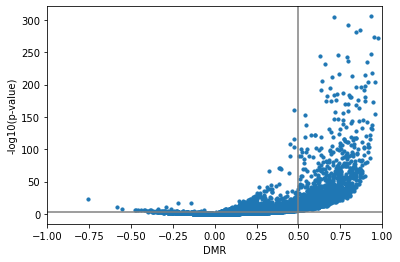

In [47]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

df = pd.read_csv("test_diffmod.table", header=0)
# note: xpore outputs conditions in alphabetical order (ex. KO_vs_WT)
pval_KOvsWT = -np.log10(np.array(df['pval_HEK293T-KO_vs_HEK293T-WT']))
dmr_KOvsWT  = np.array(df['diff_mod_rate_HEK293T-KO_vs_HEK293T-WT'])
# requires to invert dmr_KOvsWT to convert to the WT vs KO direction
pval_WTvsKO,dmr_WTvsKO  = pval_KOvsWT, -dmr_KOvsWT 
plt.scatter(dmr_WTvsKO, pval_WTvsKO,10)
plt.xlim(-1,1)
plt.xlabel("DMR")
plt.ylabel("-log10(p-value)")
## users can define the threshold for DMR and p-value
dmr_threshold = 0.5
pval_threshold = 0.001
plt.axvline(dmr_threshold, color='gray', linestyle='-')
plt.axhline(-np.log10(pval_threshold), color='gray', linestyle='-')

### Frequency of the top ten k-mers at significantly differentially modified positions.
Using only the differentially modified sites (DMR > 0.5 and p-value < 0.001) shown in the top right quadrant of the previous plot, we plotted a barplot showing the top 10 most frequently found kmers and the number of differentially modified sites for each kmer.

Text(0, 0.5, 'Frequency')

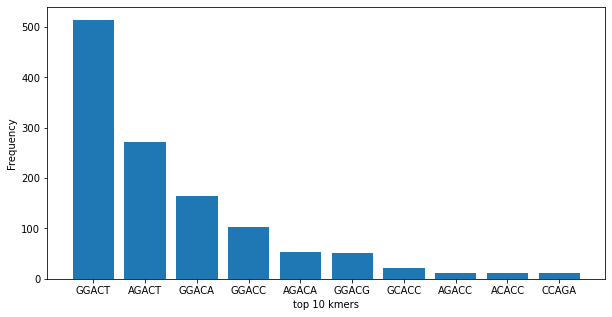

In [48]:
## filtering entries based on the p-value and dmr thresholds
dmr_threshold = 0.5
pval_threshold = 0.001
filtered_df = df.loc[(df['diff_mod_rate_HEK293T-KO_vs_HEK293T-WT'] <  pval_threshold) &
                     (abs(df['diff_mod_rate_HEK293T-KO_vs_HEK293T-WT']) > dmr_threshold)]
kmer = filtered_df['kmer']
unique, counts = np.unique(kmer, return_counts=True)
kmer_count_dict = dict(zip(unique, counts))
kmer_count_list = [(kmer,kmer_count_dict[kmer]) for kmer in kmer_count_dict]
kmer_count_list.sort(key=lambda tup: tup[1], reverse=True)
## plot bar plot
top10_kmers = kmer_count_list[:10]
selected_kmers = [kmer_count[0] for kmer_count in top10_kmers]
selected_kmer_counts =  [kmer_count[1] for kmer_count in top10_kmers]
fig = plt.figure(figsize = (10, 5))
plt.bar(selected_kmers, selected_kmer_counts)
plt.xlabel("top 10 kmers")
plt.ylabel("Frequency")

### Modification rate heatmap of the top 50 significant genes ranked by DMRs
Here we rank the diffmod table based on the DMR between WT and KO. Then, we plot the modification rates of all replicates in the WT and KO samples of the 50 most significant genes in a heatmap.

Text(204.0, 0.5, 'sample replicate')

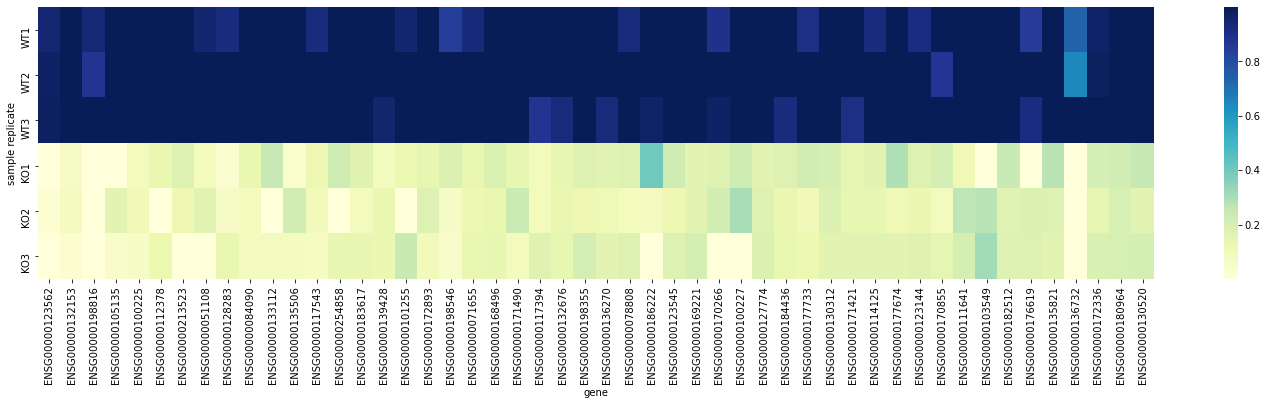

In [49]:
import seaborn as sns
dmr_ranked_df = filtered_df.sort_values('diff_mod_rate_HEK293T-KO_vs_HEK293T-WT',ascending=True)
dmr_ranked_df = dmr_ranked_df[["id","kmer","diff_mod_rate_HEK293T-KO_vs_HEK293T-WT",
                               "mod_rate_HEK293T-WT-rep1","mod_rate_HEK293T-WT-rep2","mod_rate_HEK293T-WT-rep3",
                               "mod_rate_HEK293T-KO-rep1","mod_rate_HEK293T-KO-rep2","mod_rate_HEK293T-KO-rep3"]]
modrate_array = np.array(dmr_ranked_df.dropna())
cdict={}
for entry in modrate_array[:51]: ##this gives 50 genes
    g_id, mod_rates = entry[0], list(entry[3:])
    if g_id not in cdict: ##keep the site with the highest DMR in each gene
        cdict[g_id]= mod_rates
modrate_data=[[g_id]+cdict[g_id] for g_id in cdict]

##plot heatmap
modrate_heatmap_df = pd.DataFrame.from_records(modrate_data, 
                                               columns = ["gene","WT1","WT2","WT3","KO1","KO2","KO3"],
                                               index = "gene").T
fig = plt.figure(figsize = (25, 5))
sns.heatmap(modrate_heatmap_df, cmap="YlGnBu")
plt.ylabel('sample replicate')

### The number of modified A sites of the top 50 significant genes ranked by DMRs
Here we count the number of the modified A sites of the top 50 significant genes determined by DMR (please see above) and present the information as a count heatmap.

Text(0.5, 24.0, 'gene')

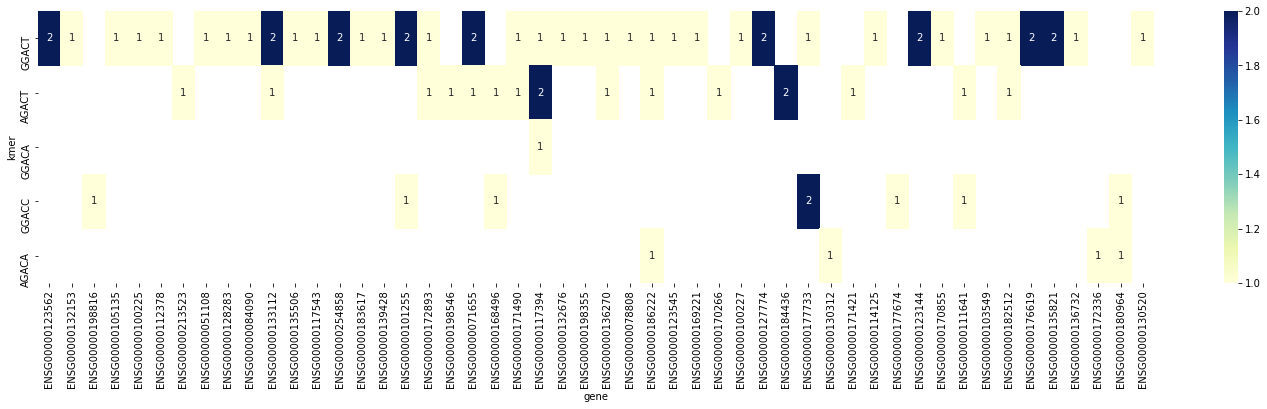

In [50]:
## limit the count heatmap to the top 5 kmers
top5_kmers = [kmer[0] for kmer in top10_kmers[:5]]
## get the genes plotted in the heatmap above
top50_genes=list(cdict.keys())
dmr_ranked_df = dmr_ranked_df[dmr_ranked_df['id'].isin(top50_genes)]
## count the occurence of each kmer
ndict={}
for id,kmer in np.array(dmr_ranked_df[["id","kmer"]]).tolist():
    if kmer not in ndict:
        ndict[kmer]={}
        ndict[kmer][id]=1
    else:
        if id in ndict[kmer]:
            ndict[kmer][id]+=1
        else:
            ndict[kmer][id]=1

kmer_gene_counts = []
for kmer in top5_kmers:
    tmp=[kmer]
    for g_id in top50_genes:
        if g_id in ndict[kmer]:
            tmp.append(ndict[kmer][g_id])
        else:
            tmp.append(np.nan)
    kmer_gene_counts.append(tmp)

## plot a subset of kmers and genes for illustration
kmer_count_heatmap_df = pd.DataFrame.from_records(kmer_gene_counts,
                                                  columns=["kmer"]+top50_genes,
                                                  index="kmer")
fig = plt.figure(figsize = (25, 5))
sns.heatmap(kmer_count_heatmap_df, annot=True, cmap="YlGnBu")
plt.xlabel('gene')